In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
print_tensor = lambda n, x: print(n, type(x), x.shape, x.min(), x.max())
sys.path.remove('/home/dejuns/git/mmseg4med')
print(sys.path)
# from pathlib import Pathth

['/home/dejuns/git/mmdet4med/demo', '/home/dejuns/miniconda3/lib/python38.zip', '/home/dejuns/miniconda3/lib/python3.8', '/home/dejuns/miniconda3/lib/python3.8/lib-dynload', '', '/home/dejuns/miniconda3/lib/python3.8/site-packages', '/home/dejuns/miniconda3/lib/python3.8/site-packages/ribfrac-1.0.0-py3.8.egg', '/home/dejuns/git/nnDetection', '/home/dejuns/git/mmdet4med', '/home/dejuns/miniconda3/lib/python3.8/site-packages/IPython/extensions', '/home/dejuns/.ipython', '/home/dejuns/git/mmdet4med']


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from mmdet.datasets.transform4med.io4med import *
from demo.visual_gt_pred import *
from monai.transforms.spatial.dictionary_ import *
import inspect


In [4]:
cohort_rt = Path('/data/lung_algorithm/data/DetFrac/processed/plan_rib_crop/KY_B1_30_crop')
store_rt = Path('/data/lung_algorithm/data/DetFrac/processed/test_elastic')
caseid = '1144929'
case_rt = cohort_rt/caseid
save_case_dir = store_rt/caseid
mkdir(save_case_dir)
case_image_format = lambda cid, n: f'{cid}_{n}.nii'

img_fn = case_image_format(caseid, 'image')

In [6]:
image3d, af = IO4Nii.read(case_rt/img_fn, verbose = False, dtype = np.int16)

In [7]:
device = 'cuda:1'
spatial_size = (160, 192, 128)
crop_starts = (32, 32, 96)
spatial_size_extend = (192, 224, 160)
rotate_range = [-15, 15]
rotate_range = [a * np.pi / 180.0 for a in rotate_range]
sigma_range = (6, 12)
scale_range = (-0.15, 0.15)
magnitude_range = (48, 64)
dtype = torch.float
mode: GridSampleModeSequence = GridSampleMode.BILINEAR
padding_mode = GridSamplePadMode.REFLECTION
# prepare image input
crop_slicer = tuple([slice(crop_starts[i], spatial_size_extend[i] + crop_starts[i]) for i in range(3)])
input_image = image3d[crop_slicer]
input_image_tensor = torch.from_numpy(input_image).float().to(device)[None, None]
print_tensor('input image', input_image_tensor)

input image <class 'torch.Tensor'> torch.float64 torch.Size([1, 1, 192, 224, 160]) tensor(-1024., device='cuda:1', dtype=torch.float64) tensor(3071., device='cuda:1', dtype=torch.float64)


[UniformSampler] -1~1, offsets <class 'torch.Tensor'> torch.float32 torch.Size([1, 3, 160, 192, 128]) tensor(-1., device='cuda:1') tensor(1.0000, device='cuda:1')


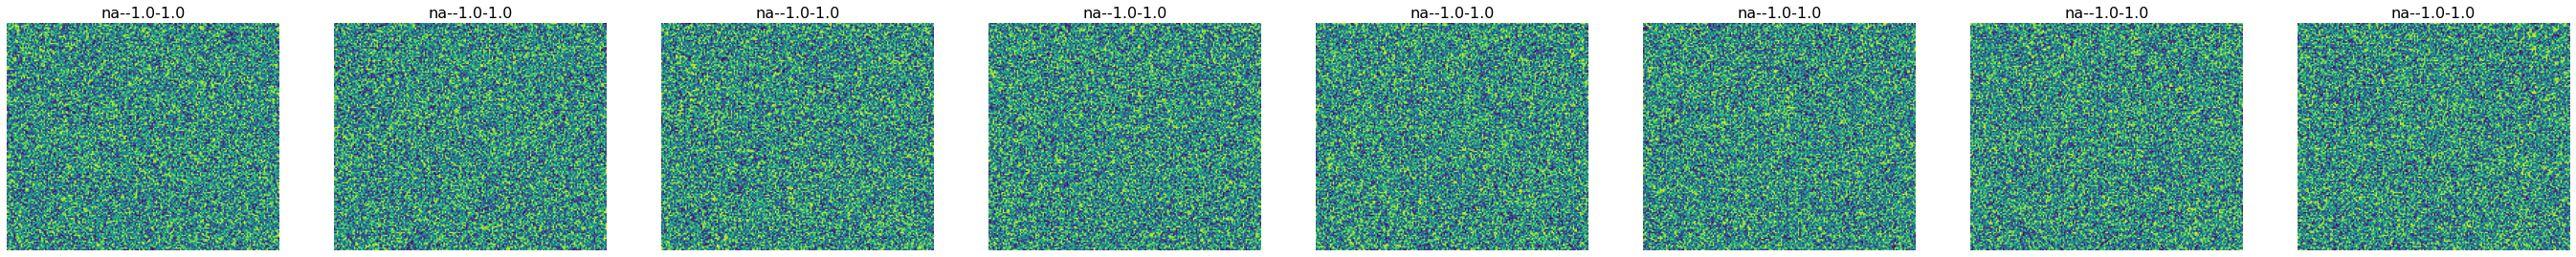

In [9]:
listfy_arr = lambda arr, dim : [a.squeeze() for a in np.split(arr, arr.shape[dim], axis = dim)]
# prepare offset 

unidist_sampler = torch.distributions.uniform.Uniform(-1.0, 1.0)
offset4d = unidist_sampler.rsample([3] + list(spatial_size)).to(dtype).to(device).unsqueeze(0)  # (-1.0, 1.0)
offset_2d_list = listfy_arr(offset4d.cpu().numpy()[0, 0], dim = -1)

print_tensor('[UniformSampler] -1~1, offsets', offset4d)
off = plotNImage(offset_2d_list[:8], rows = 1)

sigma 32.0
GaussianFilter on Offset <class 'torch.Tensor'> torch.float32 torch.Size([3, 160, 192, 128]) tensor(-0.0010, device='cuda:1') tensor(0.0012, device='cuda:1')


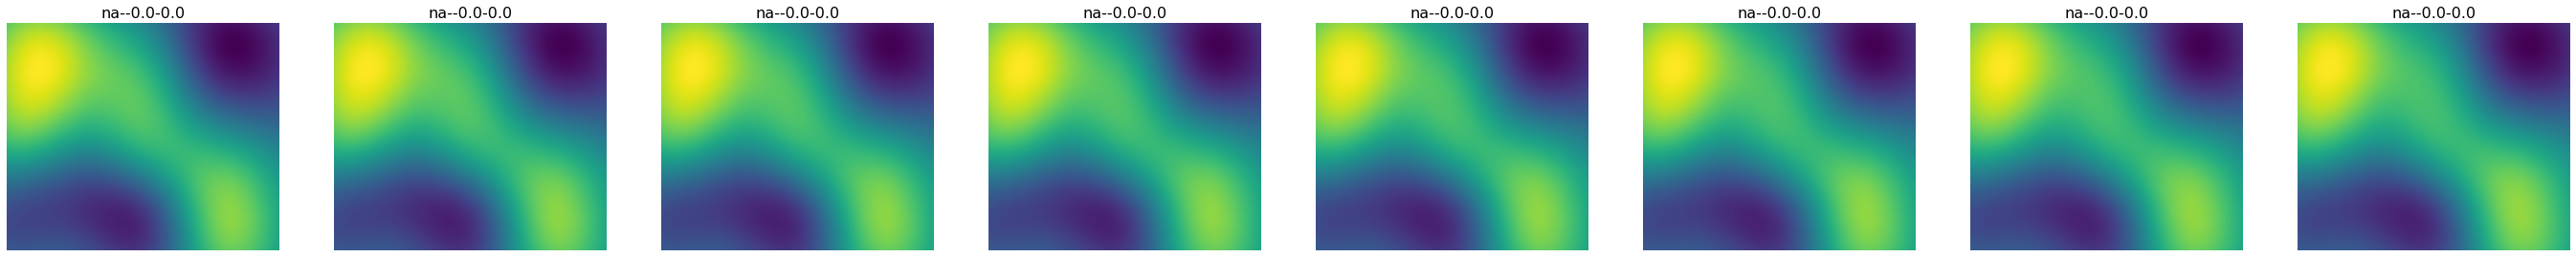

In [10]:
sigma = torch.tensor(32, device = device).to(dtype)
gaussian_ops = GaussianFilter(spatial_dims=3, sigma=sigma, truncated=3.0).to(device) # larger sigma, more flattening curve
print(f'sigma {sigma}')

offset_gaus = gaussian_ops(offset4d)[0] # -0.02, 0.02
print_tensor('GaussianFilter on Offset', offset_gaus)
offset_gaus_2d_list = listfy_arr(offset_gaus.cpu().numpy()[0], dim = -1)
a = plotNImage(offset_gaus_2d_list[:8], rows = 1)


In [24]:
rotate_range = [15] * 3
rotate_range = [a * np.pi / 180.0 for a in rotate_range]
scale_range = [0.15] * 3
translate_range = [16] * 3
rand_affine_grid = RandAffineGridGPU(rotate_range, 
                                    translate_range = translate_range, 
                                    scale_range = scale_range, device =device)
magnitude = torch.tensor(512, device = device).to(dtype)
# bigger the sigma for gaussian filter, smaller the offset sampled from uniform distribution
# which requires larger magnitude for the offset to be effective

print(f'Rotate range {rotate_range} scale range {scale_range}')
# prepare grid
grid_tensor = totensor(create_grid(spatial_size)).float() #.half()
grid4d_raw = grid_tensor.clone().to(device)
grid4d = grid_tensor.clone().to(device)
offset_scale = offset_gaus * magnitude
grid4d[:3] = grid4d_raw[:3] + offset_scale # add jitter to grid 
print_tensor('GridRaw', grid4d_raw)
print_tensor('offset scale', offset_scale)
print_tensor('Offset Grid', grid4d)


grid4d_transform = rand_affine_grid(grid = grid4d)
print_tensor('Transform grid4d', grid4d_transform)
affine_param = dict(rotate_params=rand_affine_grid.rotate_params,
            shear_params=rand_affine_grid.shear_params,
            translate_params=rand_affine_grid.translate_params,
            scale_params=rand_affine_grid.scale_params,)
print('affine params', affine_param)

Rotate range [0.2617993877991494, 0.2617993877991494, 0.2617993877991494] scale range [0.15, 0.15, 0.15]
GridRaw <class 'torch.Tensor'> torch.float32 torch.Size([4, 160, 192, 128]) tensor(-95.5000, device='cuda:1') tensor(95.5000, device='cuda:1')
offset scale <class 'torch.Tensor'> torch.float32 torch.Size([3, 160, 192, 128]) tensor(-0.5340, device='cuda:1') tensor(0.6246, device='cuda:1')
Offset Grid <class 'torch.Tensor'> torch.float32 torch.Size([4, 160, 192, 128]) tensor(-95.7157, device='cuda:1') tensor(95.7066, device='cuda:1')
affine params {'rotate_params': None, 'shear_params': None, 'translate_params': None, 'scale_params': None}
rotate affine [-0.11467900450507884, 0.16090324995976757, 0.2407698629987734] 
 [[ 0.95861026 -0.23537028  0.16020985  0.        ]
 [ 0.21908045  0.96914711  0.11294974  0.        ]
 [-0.18185193 -0.07317593  0.98059939  0.        ]
 [ 0.          0.          0.          1.        ]]
translate affine [5.950187316011419, -13.97776366713671, 13.378984

In [14]:
# print(dir(RandAffineGridGPU))
# print(RandAffineGridGPU.__class__)
inspect.getfile(rand_affine_grid.__class__)

'/home/dejuns/git/mmdet4med/monai/transforms/spatial/array_.py'

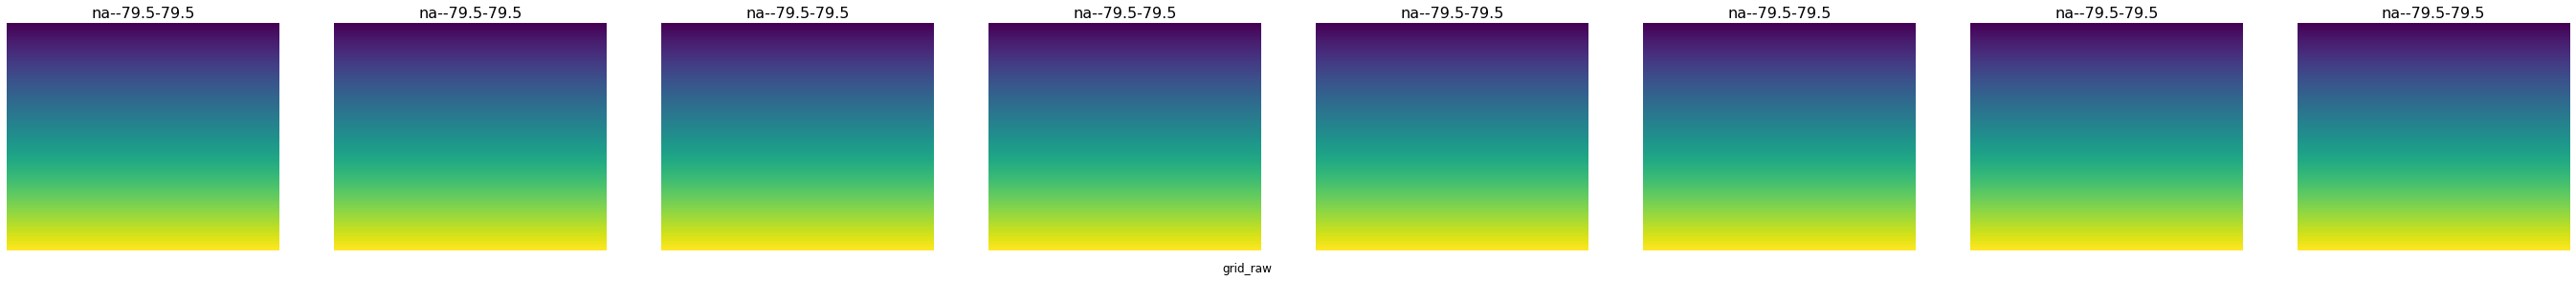

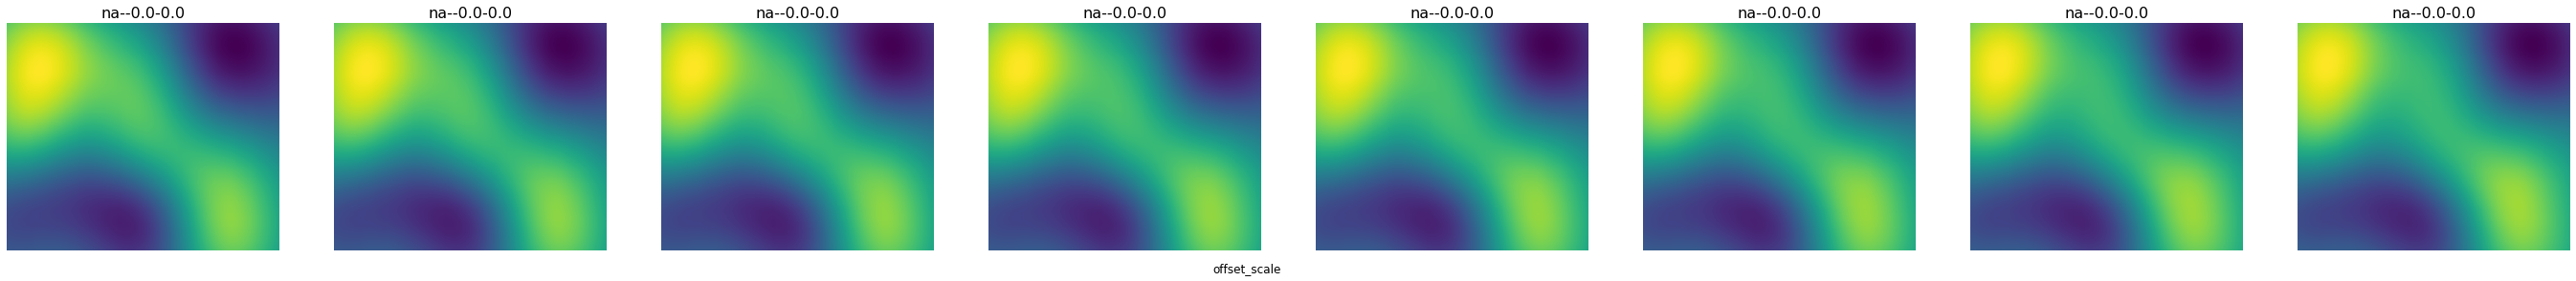

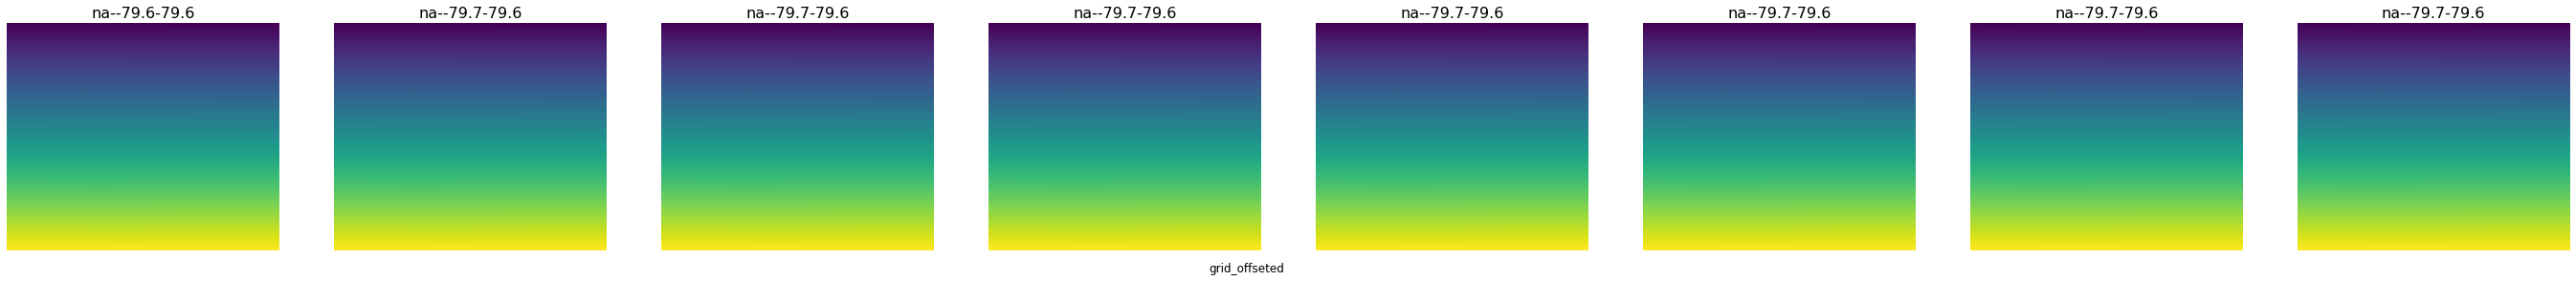

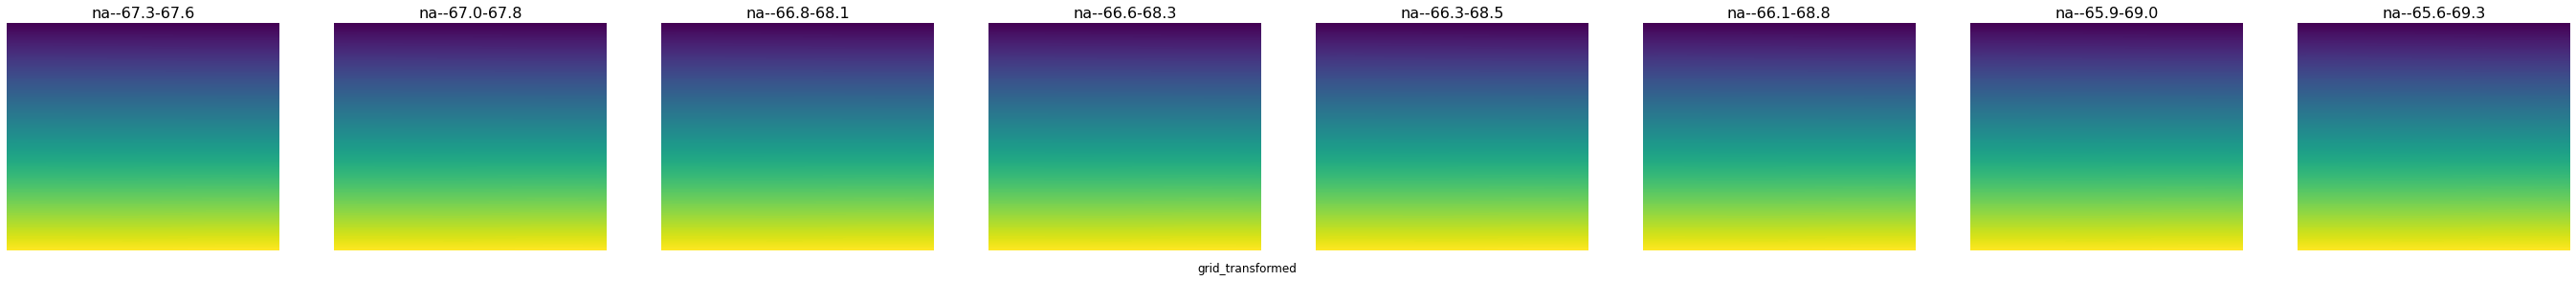

In [15]:
show_dim = 2
gridraw_2d_list = listfy_arr(grid4d_raw.cpu().numpy()[0], dim = show_dim)
raw = plotNImage(gridraw_2d_list[:16:2], fig_title='grid_raw')

offscale_2d_list = listfy_arr(offset_gaus.cpu().numpy()[0], dim = show_dim)
off = plotNImage(offscale_2d_list[:16:2], fig_title='offset_scale')

grid_2d_list = listfy_arr(grid4d.cpu().numpy()[0], dim = show_dim)
jitter = plotNImage(grid_2d_list[:16:2], fig_title='grid_offseted')

gridtrans_2d_list = listfy_arr(grid4d_transform.cpu().numpy()[0], dim = show_dim)
trans = plotNImage(gridtrans_2d_list[:16:2], fig_title='grid_transformed')



In [19]:
# prepare operators
resampler = ResampleGPU(as_tensor_output=True, device=device, verbose = True)
image_transform = resampler(input_image_tensor, grid = grid4d_transform, mode = mode, padding_mode=padding_mode)
image_transform_np = image_transform[0, 0].cpu().numpy()
print_tensor('final transform img', image_transform_np)

grid norm 3c torch.Size([192, 224, 160]) <class 'torch.Tensor'> torch.float32 torch.Size([3, 160, 192, 128]) tensor(-1.0717, device='cuda:1') tensor(1.0975, device='cuda:1')
grid norm 4d <class 'torch.Tensor'> torch.float32 torch.Size([1, 160, 192, 128]) tensor(1., device='cuda:1') tensor(1., device='cuda:1')
[2, 1, 0]
grid norm permute <class 'torch.Tensor'> torch.float32 torch.Size([160, 192, 128, 3]) tensor(-1.0717, device='cuda:1') tensor(1.0975, device='cuda:1')
mode bilinear pad border
input <class 'torch.Tensor'> torch.float64 torch.Size([1, 1, 192, 224, 160]) tensor(-1024., device='cuda:1', dtype=torch.float64) tensor(3071., device='cuda:1', dtype=torch.float64)
output <class 'torch.Tensor'> torch.float32 torch.Size([1, 1, 160, 192, 128]) tensor(-1023.1191, device='cuda:1') tensor(1076.3164, device='cuda:1')
final transform img <class 'numpy.ndarray'> float32 (160, 192, 128) -1023.1191 1076.3164


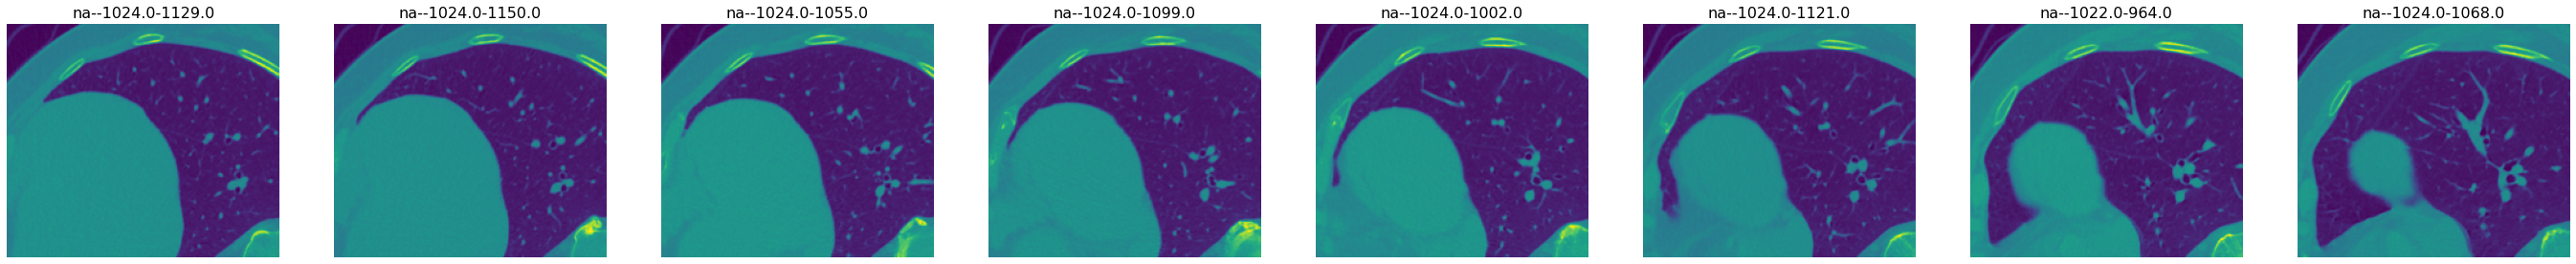

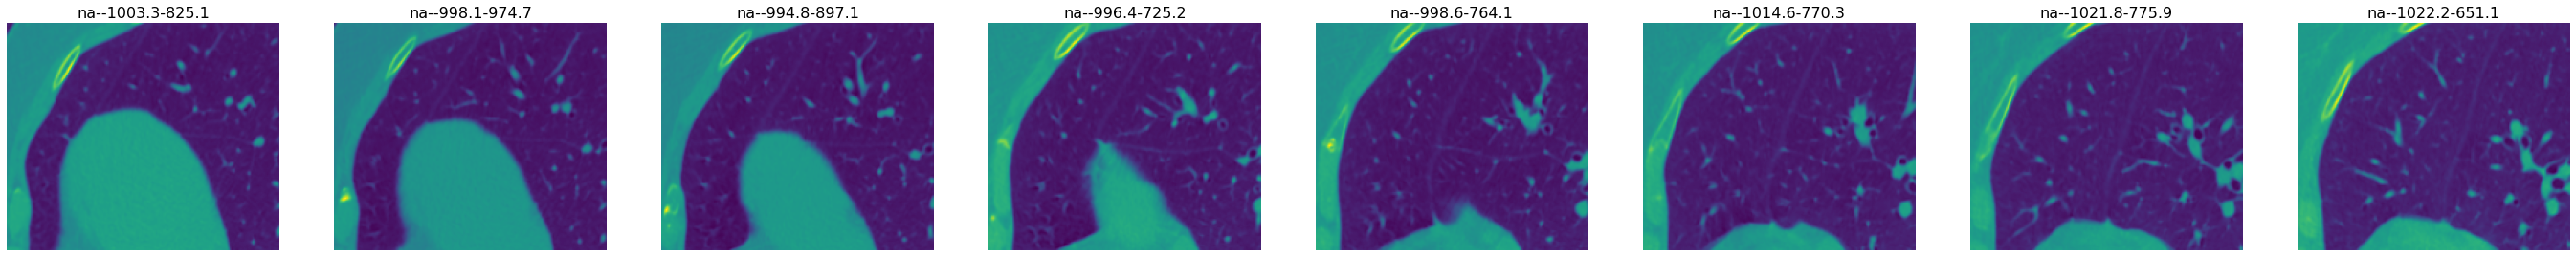

'/data/lung_algorithm/data/DetFrac/processed/test_elastic/1144929/transform_image.nii.gz'

In [20]:
show_dim = 2
imgraw_2d_list = listfy_arr(input_image, show_dim)
rawi = plotNImage(imgraw_2d_list[:32:4], )

imgtrans_2d_list = listfy_arr(image_transform_np, show_dim)
transi = plotNImage(imgtrans_2d_list[:32:4], )

IO4Nii.write(input_image, save_case_dir, 'input_image_crop', affine_matrix=af)
IO4Nii.write(image_transform_np, save_case_dir, 'transform_image', affine_matrix=af)